# 时间序列预测
用ARIMA做时间序列预测，但有些问题照例是搞不清的。比如我就不知道该怎么选MA和AR，我只会ARIMA。

1. 观察自相关图（ACF）和偏自相关图（PACF），根据图形特征来选择 AR 和 MA 的阶数。通常，AR 阶数为 ACF 截尾点之前最后一个显著的阶数，MA 阶数为 PACF 截尾点之前最后一个显著的阶数。
2. 选择差分阶数，以使得差分后的序列具有平稳性。可以使用ADF检验等平稳性检验方法进行判断。
3. 根据信息准则（如AIC、BIC）来选择最终的ARIMA模型。信息准则越小，说明模型越好。
4. 对所选的ARIMA模型进行诊断检验，例如检查残差序列是否具有平稳性、是否存在自相关和偏自相关等。
5. 对模型进行预测，并对预测结果进行评估。可以使用均方根误差（RMSE）或平均绝对误差（MAE）等指标来评估预测结果的准确性。


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

raw=pd.read_excel("./../Problem_C_Data_Wordle.xlsx")
dateAndrepos=raw.loc[:,['Date','Number of  reported results']]
dateAndrepos

,Date,Number of reported results
0,1/7/22,80630
1,1/8/22,101503
2,1/9/22,91477
3,1/10/22,107134
4,1/11/22,153880
...,...,...
350,12/27/22,20879
351,12/28/22,20160
352,12/29/22,20001
353,12/30/22,21204


Text(0, 0.5, 'Reports Number')

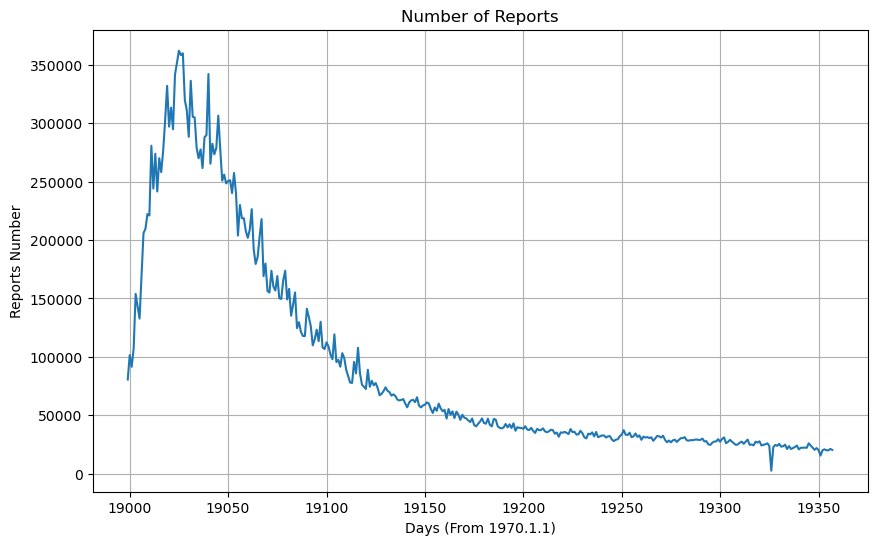

In [2]:
# 时间数字化
date = dateAndrepos['Date'].apply(lambda x:pd.to_datetime(x))
date=(pd.to_numeric(pd.to_datetime(date))/(3600*24*1e9)).astype(int)
repos=dateAndrepos['Number of  reported results']

plt.figure(figsize=(10, 6))

plt.plot(date, dateAndrepos['Number of  reported results'])
plt.grid(True)
# plt.legend()
plt.title("Number of Reports")
plt.xlabel("Days (From 1970.1.1)")
plt.ylabel("Reports Number")

ADF统计量: -5.465670
p-value: 0.000002
Lags used: 17
观测值的个数: 336
临界值(1): -3.449963
临界值(5): -2.870181
临界值(10): -2.571373


Text(0, 0.5, 'Report Number')

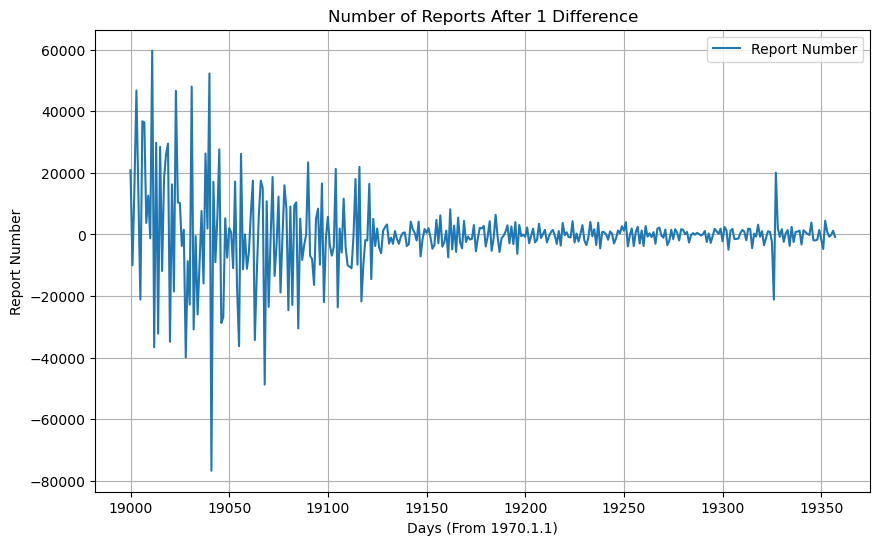

In [3]:
# 平稳性检验
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_predict


def ADFCheck(ts):
    result = sm.tsa.adfuller(ts)
    print('ADF统计量: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Lags used: %d' % result[2])
    print('观测值的个数: %d' % result[3])
    print('临界值(1): %f' % result[4]['1%'])
    print('临界值(5): %f' % result[4]['5%'])
    print('临界值(10): %f' % result[4]['10%'])

    return result

repo_diff1=repos.diff(1)
ADFCheck(repo_diff1.dropna())
plt.figure(figsize=(10, 6))
plt.plot(date, repo_diff1,label='Report Number')
plt.grid(True)
plt.legend()
plt.title("Number of Reports After 1 Difference")
plt.xlabel("Days (From 1970.1.1)")
plt.ylabel("Report Number")

# 虽然貌似不用差分，原数据就已经满足平稳性，不过显然差分一次更平稳，那就差分一次

现在，ADF验证终于是通过了：
ADF统计量: -5.465670
p-value: 0.000002
Lags used: 17
观测值的个数: 336
临界值(1): -3.449963
临界值(5): -2.870181
临界值(10): -2.571373

d:\Pro\miniconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Pro\miniconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\Pro\miniconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Pro\miniconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Pro\miniconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Lik

{'aic':              0            1            2            3            4
0  9433.734215  7667.792638  7666.640781  7682.904235  7671.580742
1  7659.236082  7660.426849  7664.527381  7681.617956  7645.224153
2  7660.273371  7662.377298  7666.303083  7657.638114  7647.230662
3  7660.491862  7663.106828  7655.134210  7640.231711  7621.704958
4  7663.039864  7643.110135  7608.901836  7657.441999  7612.979953, 'bic':              0            1            2            3            4
0  9441.478450  7679.408992  7682.129252  7702.264824  7694.813449
1  7670.852435  7675.915320  7683.887970  7704.850663  7672.328978
2  7675.761842  7681.737887  7689.535790  7684.742938  7678.207605
3  7679.852451  7686.339534  7682.239034  7671.208653  7656.554018
4  7686.272571  7670.214959  7639.878778  7692.291060  7651.701131, 'aic_min_order': (4, 2), 'bic_min_order': (4, 2)}
                                    SARIMAX Results                                    
Dep. Variable:     Number of  reported re

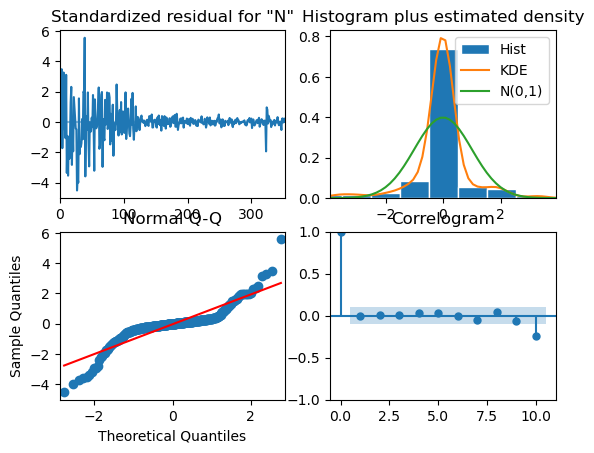

<Figure size 1000x800 with 0 Axes>

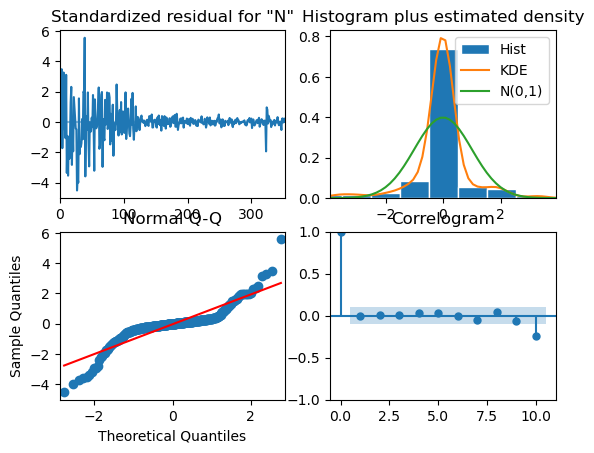

In [4]:
# 暴力搜索所有可能的ARIMA模型
arima_order = sm.tsa.arma_order_select_ic(repo_diff1, max_ar=4, max_ma=4, ic=['aic', 'bic'], trend='c')

# 打印所有可能模型的AIC和BIC
print(arima_order)

# 选择具有最小AIC和BIC的模型
p, q = arima_order.aic_min_order
model = sm.tsa.ARIMA(repo_diff1, order=(p, 1, q))
result = model.fit()

# 打印模型信息和诊断结果
print(result.summary())
plt.figure(figsize=(10, 8))
result.plot_diagnostics()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


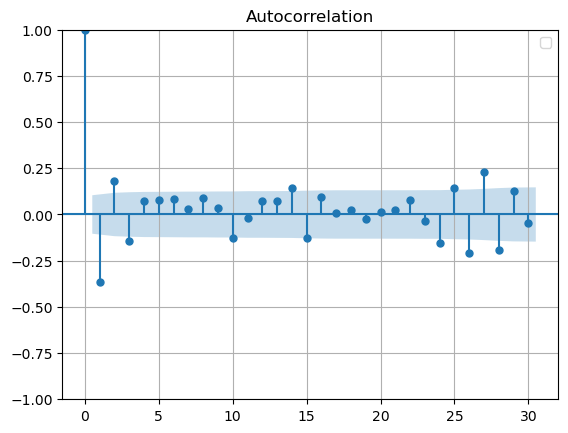

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


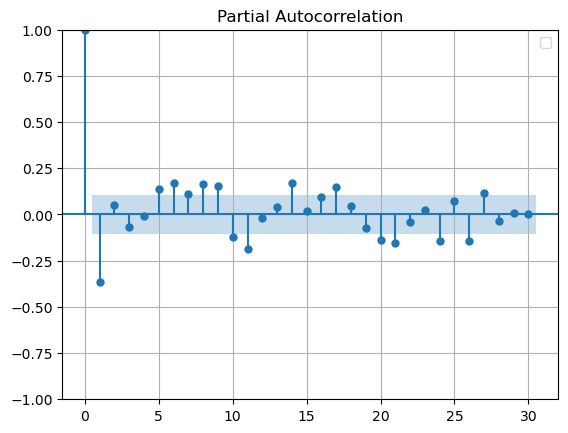

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# plt.figure(figsize=(40, 15))
plot_acf(repo_diff1.dropna(), lags=30)
plt.grid(True)
plt.legend()
# plt.title("Number of Reports After 1 Difference")
# plt.xlabel("Days (From 1970.1.1)")
# plt.ylabel("Report Number")
plt.show()
plot_pacf(repo_diff1.dropna(), lags=30, method='ywm')
plt.grid(True)
plt.legend()
# plt.title("Number of Reports After 1 Difference")
# plt.xlabel("Days (From 1970.1.1)")
# plt.ylabel("Report Number")
plt.show()

# 参数选择
我们可以看到大概合适的选择就在那一片，所以直接穷举64个组合和3类不同的优化方法，选出偏差最小的组合：
- 1 次差分；
- 使用 p, d, q 为 18，1，8 的组合训练；
- 使用 innovations_mle 优化；
这就是我们的结论。

In [6]:
train_test_rate = 0.8
train_validate_rate = 0.8

dataSet=repo_diff1.dropna()

test_split = int(train_test_rate*len(dataSet))
validate_split = int(train_validate_rate*test_split)

trainningSet=dataSet.loc[0:test_split]
testSet=dataSet.loc[test_split+1:len(dataSet)]
validateSet=trainningSet.loc[validate_split+1:len(trainningSet)]
trainningSet=trainningSet.loc[0:validate_split]

p,d,q=20,1,5

def TrainTest_ARIMA(train, test, order, showPic=True, method='statespace'):
    # Train
    model=ARIMA(train, order=order).fit(method=method)# type: ARIMAResults

    # test
    prd=model.predict(len(train), len(train)+len(test)-1)
    if showPic:
        fig1,ax1=plt.subplots(figsize=(10,6))
        ax1.grid(True)
        ax1.legend()
        ax1.set_xlabel("Times")
        ax1.set_title("Difference Between Prediction And Ground Truth")
        ax1.set_ylabel("Number of Reports (After 1 Difference)")
        ax1.plot(range(0, len(train)+len(test)), np.append(train, test), label="Ground Truth")
        ax1.plot(range(len(train), len(train)+len(prd)), prd, label="Prediction")
        plt.show(fig1)

        fig2,ax2=plt.subplots(figsize=(10,6))
        ax2.grid(True)
        ax2.legend()
        ax2.set_title("Difference Between Prediction And Ground Truth")
        ax2.set_xlabel("Times")
        ax2.set_ylabel("Number of Reports (After 1 Difference)")
        ax2.plot(range(len(train),len(train)+len(test)), test, label="Ground Truth")
        ax2.plot(range(len(train),len(train)+len(prd)), prd, label="Prediction")
        plt.show(fig2)

    # count
    return ((prd-test)**2).mean()

In [7]:
pqTests = pd.DataFrame(index=range(2, 34, 4), columns=range(2, 10))

for pTest in pqTests.index:
    for qTest in pqTests.columns:
        pqTests.at[pTest,qTest] = TrainTest_ARIMA(trainningSet.to_numpy(), validateSet.to_numpy(), (pTest, d, qTest), False, 'innovations_mle')

# dataSet
pqTests

d:\Pro\miniconda\lib\site-packages\statsmodels\tsa\arima\model.py:403: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  warnings.warn('Provided `endog` series has been differenced'
d:\Pro\miniconda\lib\site-packages\statsmodels\tsa\arima\model.py:403: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  warnings.warn('Provided `endog` series has been differenced'
d:\Pro\miniconda\lib\site-packages\statsmodels\tsa\arima\model.py:403: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  warnings.warn('Provided `endog` series has been differenced'
d:\Pro\miniconda\lib\site-packages\statsmodels\tsa\arima\model.py:403: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter

,2,3,4,5,6,7,8,9
2,4777984.865707,4852183.054968,5502577.282721,5941572.201005,4703955.927613,4680194.432133,4617672.543083,4601062.51522
6,4762928.645507,4072614.82436,6258113.399057,5494728.942483,6760861.108814,14649929.628058,12644317.038338,21241546.785803
10,4724839.467677,4633160.629958,4606663.386816,4749989.789823,4828327.678772,10995507.706753,6256567.582203,10628936.242922
14,5387232.767347,4873539.063606,4762835.264972,5086927.337288,5371898.328969,5011034.981675,7088058.891448,6434550.535239
18,5620954.261136,4699109.869135,5072694.925898,4744020.744014,6671341.828464,6746121.296638,3842471.046365,17461037.840234
22,5784583.89816,7051384.174864,7378766.770566,5291011.894465,4910245.131116,4796584.503708,5284062.091503,5797159.570983
26,5572931.608963,5577617.74309,4836642.108567,5018905.074086,5278174.331282,8941822.502162,8890375.553684,6007658.15691
30,5373469.267471,5319476.162837,5662893.362902,5444090.510072,7465602.150947,11209145.822664,6471279.284423,10619740.667933


C:\Users\31368\AppData\Local\Temp\ipykernel_1472\1233656525.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


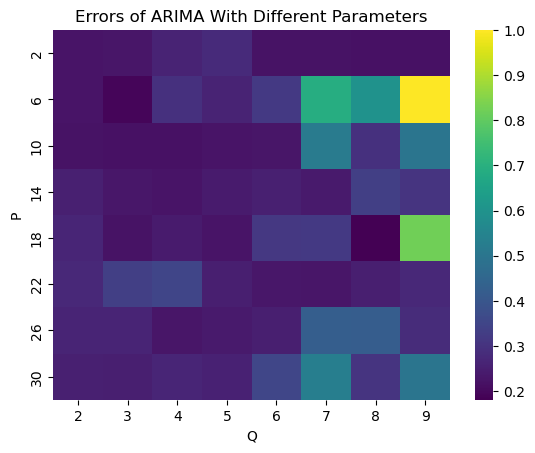

In [18]:
import seaborn as sb

fig,ax=plt.subplots()
sb.heatmap((pqTests/pqTests.max().max()).astype(float), cmap="viridis")
ax.set_title("Errors of ARIMA With Different Parameters")
ax.set_ylabel("P")
ax.set_xlabel("Q")
fig.show()

# pqTests.to_excel("P&Q Test_burg.xlsx")

MultiIndex([(18, 8)],
           )


d:\Pro\miniconda\lib\site-packages\statsmodels\tsa\arima\model.py:403: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  warnings.warn('Provided `endog` series has been differenced'
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


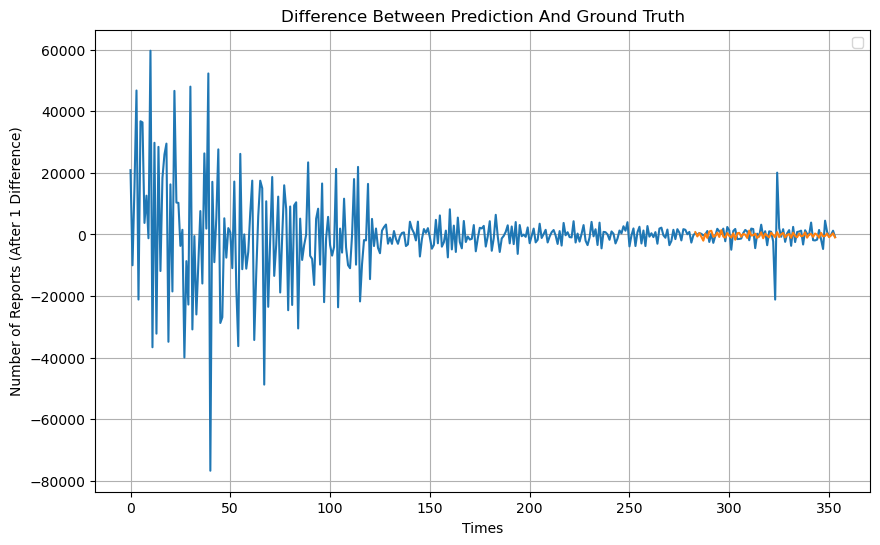

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


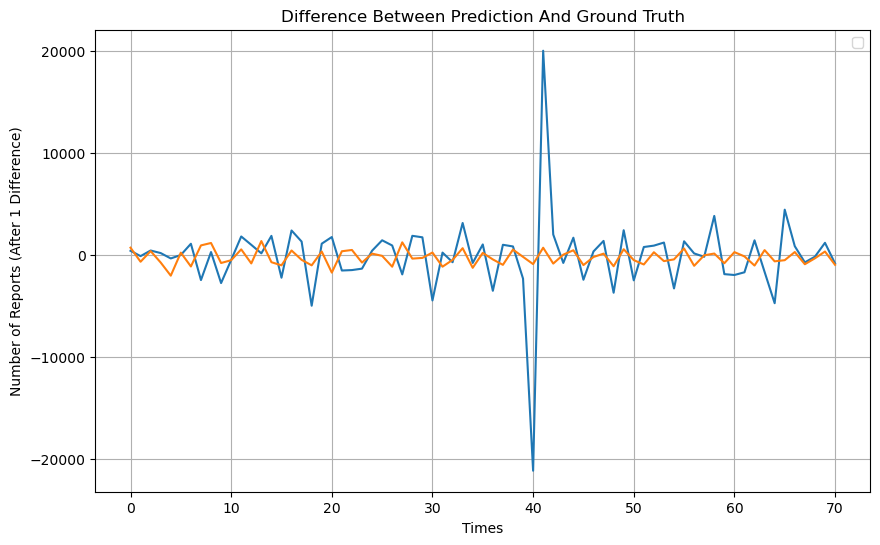

14993819.319086626

In [50]:
"""选择里面误差较小的作为参数"""

indices = pqTests.where(pqTests<3941822).stack().index
print(indices)

# TrainTest_ARIMA(trainningSet.to_numpy(), validateSet.to_numpy(), (18, d, 8), True,'innovations_mle')
TrainTest_ARIMA(np.append(trainningSet, validateSet), testSet, (18,1,8), True, 'innovations_mle')

In [10]:
# TrainTest_ARIMA(np.append(trainningSet, validateSet), testSet, (10,1,2))
model = ARIMA(np.append(trainningSet, validateSet), order=(18, 1, 8)).fit(method='innovations_mle')# type:ARIMAResults
forecast = model.get_forecast(steps=len(testSet), alpha=0.01, typ='mean') 
confs=forecast.conf_int(alpha=0.1)


d:\Pro\miniconda\lib\site-packages\statsmodels\tsa\arima\model.py:403: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  warnings.warn('Provided `endog` series has been differenced'


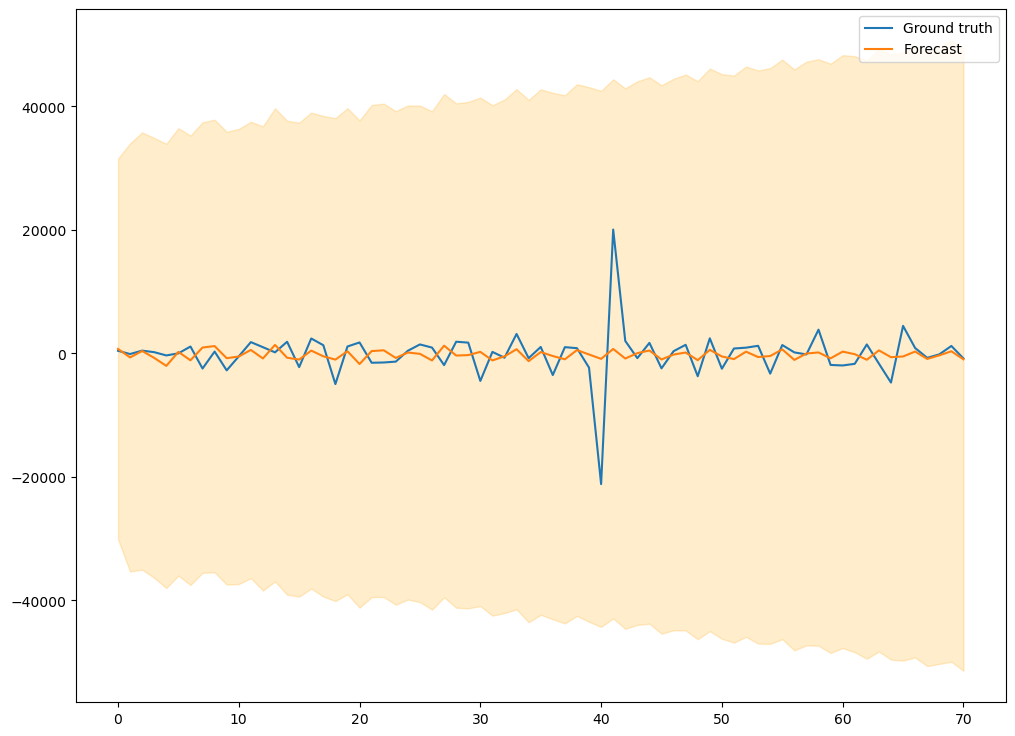

In [11]:
fig,ax=plt.subplots(figsize=(12,9))
ax.plot(testSet.to_numpy(),label="Ground truth")
ax.fill_between(range(len(testSet)), confs[:,0], confs[:,1], alpha=0.2, color='orange')
ax.plot(model.forecast(len(testSet)),label="Forecast")
ax.legend()
# confs

In [36]:
# 差分复原

back = pd.Series(index=raw.loc[:,'Date'], dtype='float64')
back.iloc[1:]=dataSet
back.iloc[0]=repos.loc[1]
back = back.cumsum()
forecasts = model.get_forecast(steps=60, alpha=0.1, typ='mean') 
forecast = model.forecast(60)
forecast[0]+=back[len(back)-1]
final = forecast.cumsum().round()
final
# back

array([41977., 41321., 41710., 40976., 38955., 39192., 38072., 39021.,
       40206., 39427., 38923., 39480., 38660., 40034., 39334., 38325.,
       38775., 38305., 37297., 37644., 35922., 36295., 36795., 36058.,
       36199., 36122., 34979., 36228., 35879., 35600., 35848., 34708.,
       34230., 34905., 33654., 33867., 33439., 32479., 33015., 32839.,
       31951., 32672., 31836., 31876., 32346., 31361., 31173., 31312.,
       30216., 30790., 30294., 29369., 29646., 29051., 28627., 29272.,
       28216., 28194., 28343., 27540.])

array([[-30095.16024534,  31542.62953351],
       [-35322.47882163,  34011.03707584],
       [-35022.19662167,  35799.93591646],
       [-36354.73878041,  34887.94082038],
       [-37995.18240154,  33951.42137041],
       [-35997.29944572,  36472.81645711],
       [-37509.30445795,  35269.43265864],
       [-35536.16353956,  37433.58795942],
       [-35475.51205415,  37845.74695147],
       [-37442.36188055,  35884.01480689],
       [-37363.34510432,  36354.22518589],
       [-36398.36913545,  37514.01061118],
       [-38415.24198611,  36774.40412707],
       [-36937.63916969,  39686.1045669 ],
       [-39075.66177211,  37674.87959101],
       [-39389.81125017,  37373.24320217],
       [-38102.14206857,  39000.50799142],
       [-39388.16884529,  38448.56739912],
       [-40110.91079964,  38095.35797527],
       [-39015.75726063,  39709.62708409],
       [-41172.75218199,  37728.1074754 ],
       [-39481.04955009,  40227.42719561],
       [-39448.84799603,  40449.32954966],
       [-40

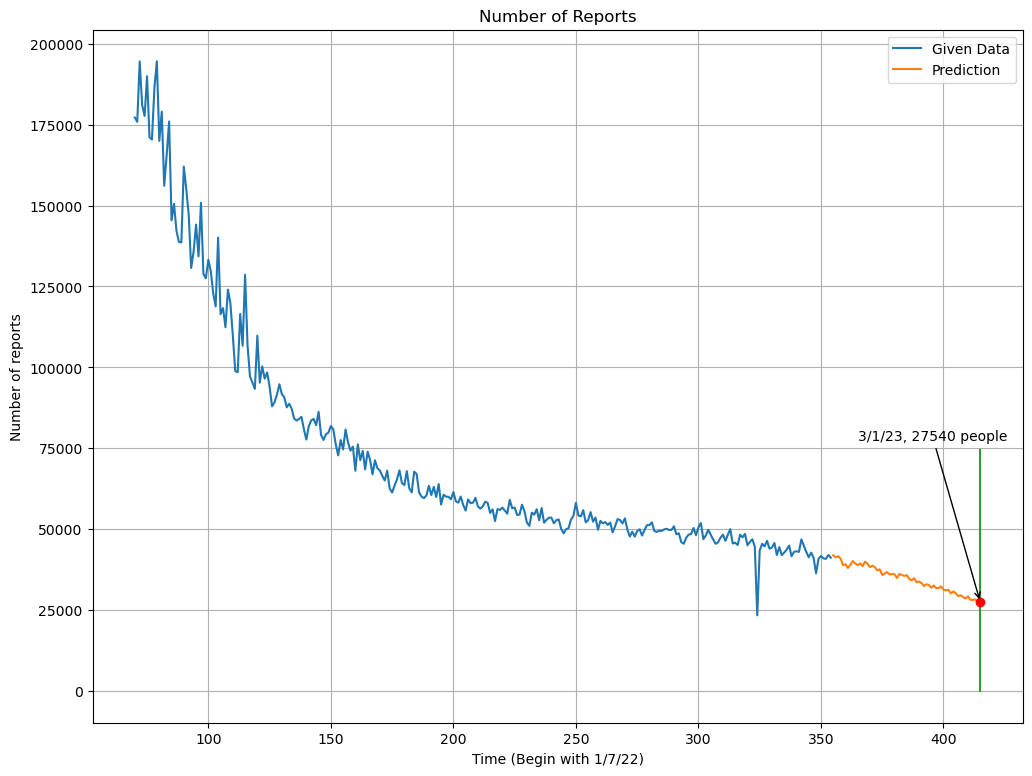

In [49]:
fig,ax=plt.subplots(figsize=(12, 9))

offset = 70
ax.plot(range(offset,len(back)),back[offset:], label ="Given Data")
ax.plot(range(len(back),len(back)+60),final, label ="Prediction")
ax.set_xlabel("Time (Begin with 1/7/22)")
ax.set_ylabel("Number of reports")
ax.set_title("Number of Reports")
# ax.scatter([], final[], color='red')
# ax.errorbar(len(back)+60,final[len(final)-1],  final[len(final)-1]-forecasts.conf_int(alpha=0.1)[len(final)-1][0])
# ax.errorbar(len(back)+60,final[len(final)-1],  final[len(final)-1]-forecasts.conf_int(alpha=0.1)[len(final)-1][0])
ax.plot([len(back)+60,len(back)+60],[0,final[len(final)-1]+forecasts.conf_int(alpha=0.1)[len(final)-1][1]])
ax.plot(len(back)+60,final[len(final)-1],'ro')
ax.annotate("3/1/23, "+str(int(final[len(final)-1]))+" people", xy=(len(back)+60,final[len(final)-1]),xytext=(len(back)+10,final[len(final)-1]+50000),arrowprops=dict(facecolor='red', arrowstyle='->'))
ax.legend()
ax.grid(True)

confs